# DÉTECTION DE PNEUMONIE VIA TRANSFER LEARNING
# Classification binaire de radiographies thoraciques

## Objectif

Créer un système d'IA pour détecter la pneumonie à partir de radiographies thoraciques.

**Approche :**
- CNN simple (baseline)
- Transfer Learning avec VGG16

**Dataset :** Chest X-Ray Images (Kaggle) - 5,863 images - 2 classes (NORMAL / PNEUMONIA)

## Import et configuration 

In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import shuffle, class_weight
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__} | GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

/Users/bvfode/Desktop/CNN_Transfert_Learning/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow: 2.16.2 | GPU: True


## Configuration

In [2]:
#Chemins
DATA_DIR = 'data/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Paramètres
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS_CNN = 5
EPOCHS_TL = 3
LEARNING_RATE = 0.001

# Labels
LABEL_MAP = {'NORMAL': 0, 'PNEUMONIA': 1}
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

print(f"Config: {IMG_SIZE} | Batch: {BATCH_SIZE} | Epochs CNN: {EPOCHS_CNN} | TL: {EPOCHS_TL}")
os.makedirs('models', exist_ok=True)

Config: (150, 150) | Batch: 32 | Epochs CNN: 5 | TL: 3


## Exploration des données 

In [3]:
def explore_dataset(data_dir):
    counts = {}
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_dir, class_name)
        counts[class_name] = len([f for f in os.listdir(class_dir) 
                                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    total = sum(counts.values())
    for c, n in counts.items():
        print(f"{c:12} : {n:5} ({n/total*100:.1f}%)")
    return counts

print("\n=== TRAIN ===")
train_counts = explore_dataset(TRAIN_DIR)

print("\n=== TEST ===")
test_counts = explore_dataset(TEST_DIR)


=== TRAIN ===
NORMAL       :  1341 (25.7%)
PNEUMONIA    :  3875 (74.3%)

=== TEST ===
NORMAL       :   234 (37.5%)
PNEUMONIA    :   390 (62.5%)


## Chargement et preprocessing 

In [4]:
def load_images_from_folder(folder, label, img_size=IMG_SIZE):
    """
    Charge les images d'un dossier et retourne X, y
    
    Args:
        folder: chemin du dossier contenant les images
        label: label à assigner (0 ou 1)
        img_size: taille de redimensionnement des images
    
    Returns:
        images: array numpy des images normalisées
        labels: array numpy des labels
    """
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            try:
                # Lecture en niveaux de gris
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # Redimensionnement
                img = cv2.resize(img, img_size)
                # Normalisation [0, 1]
                img = img / 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Erreur avec {filename}: {e}")
    
    return np.array(images), np.array(labels)

print(" Chargement des données d'entraînement...")
X_train_normal, y_train_normal = load_images_from_folder(
    os.path.join(TRAIN_DIR, 'NORMAL'), LABEL_MAP['NORMAL']
)
X_train_pneumonia, y_train_pneumonia = load_images_from_folder(
    os.path.join(TRAIN_DIR, 'PNEUMONIA'), LABEL_MAP['PNEUMONIA']
)

print(" Chargement des données de test...")
X_test_normal, y_test_normal = load_images_from_folder(
    os.path.join(TEST_DIR, 'NORMAL'), LABEL_MAP['NORMAL']
)
X_test_pneumonia, y_test_pneumonia = load_images_from_folder(
    os.path.join(TEST_DIR, 'PNEUMONIA'), LABEL_MAP['PNEUMONIA']
)

# Fusion et mélange des données
X_train = np.concatenate([X_train_normal, X_train_pneumonia])
y_train = np.concatenate([y_train_normal, y_train_pneumonia])
X_test = np.concatenate([X_test_normal, X_test_pneumonia])
y_test = np.concatenate([y_test_normal, y_test_pneumonia])

# Mélange aléatoire pour éviter les biais d'ordre
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Reshape pour CNN (ajout de la dimension du canal)
X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

print(f"\n Données chargées:")
print(f"   Train: {X_train.shape} | Test: {X_test.shape}")
print(f"   Distribution train: Normal={np.sum(y_train==0)}, Pneumonia={np.sum(y_train==1)}")
print(f"   Distribution test: Normal={np.sum(y_test==0)}, Pneumonia={np.sum(y_test==1)}")

 Chargement des données d'entraînement...
 Chargement des données de test...

 Données chargées:
   Train: (5216, 150, 150, 1) | Test: (624, 150, 150, 1)
   Distribution train: Normal=1341, Pneumonia=3875
   Distribution test: Normal=234, Pneumonia=390


## Visualisation d'exemples d'images

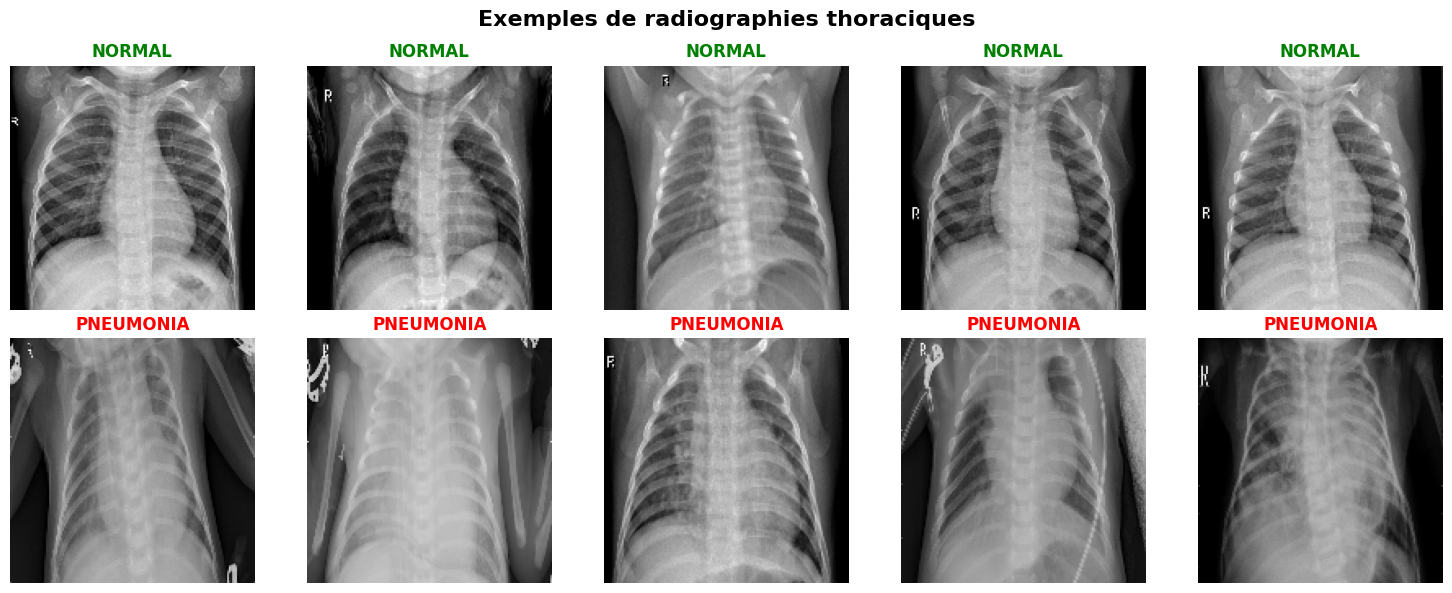

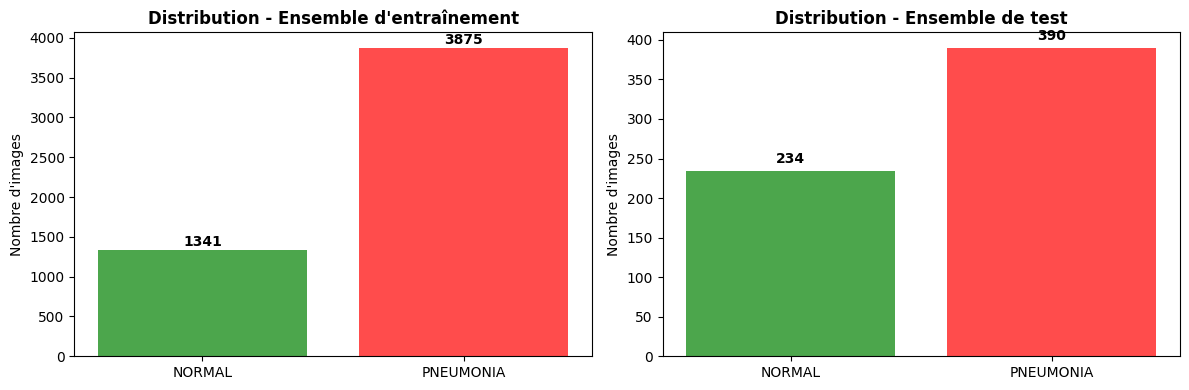

📊 Déséquilibre des classes (train): 2.89:1 (Pneumonia:Normal)


In [5]:
# Visualisation d'échantillons de chaque classe
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Exemples de radiographies thoraciques', fontsize=16, fontweight='bold')

# Images normales
for i in range(5):
    idx = np.where(y_train == 0)[0][i]
    axes[0, i].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[0, i].set_title('NORMAL', color='green', fontweight='bold')
    axes[0, i].axis('off')

# Images avec pneumonie
for i in range(5):
    idx = np.where(y_train == 1)[0][i]
    axes[1, i].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[1, i].set_title('PNEUMONIA', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
train_counts = [np.sum(y_train==0), np.sum(y_train==1)]
axes[0].bar(CLASS_NAMES, train_counts, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Distribution - Ensemble d\'entraînement', fontweight='bold')
axes[0].set_ylabel('Nombre d\'images')
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Test
test_counts = [np.sum(y_test==0), np.sum(y_test==1)]
axes[1].bar(CLASS_NAMES, test_counts, color=['green', 'red'], alpha=0.7)
axes[1].set_title('Distribution - Ensemble de test', fontweight='bold')
axes[1].set_ylabel('Nombre d\'images')
for i, v in enumerate(test_counts):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Déséquilibre des classes (train): {train_counts[1]/train_counts[0]:.2f}:1 (Pneumonia:Normal)")

## CNN simple (Baseline)

**Objectif:** Créer un modèle de référence simple pour établir une baseline de performance.

**Architecture:**
- 3 blocs convolutionnels (Conv2D + MaxPooling)
- Couches fully-connected avec Dropout
- Fonction d'activation: ReLU
- Sortie: Sigmoid (classification binaire)

In [6]:
def build_simple_cnn(input_shape=(150, 150, 1)):
    """
    Construit un CNN simple comme modèle baseline
    
    Architecture:
    - 3 blocs Conv2D + MaxPooling2D avec filtres croissants (32, 64, 128)
    - Flatten + Dense layers avec Dropout pour régularisation
    - Sortie binaire avec activation sigmoid
    """
    model = Sequential([
        # Bloc 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Bloc 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Bloc 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten et Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Régularisation pour éviter l'overfitting
        Dense(1, activation='sigmoid')  # Sortie binaire
    ])
    
    return model

# Construction du modèle
cnn_model = build_simple_cnn(input_shape=X_train.shape[1:])

# Compilation
cnn_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Affichage de l'architecture
print("📐 Architecture du CNN simple:")
cnn_model.summary()

2025-12-30 18:00:54.238765: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-30 18:00:54.238822: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-30 18:00:54.238828: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-30 18:00:54.238891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-30 18:00:54.238969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


📐 Architecture du CNN simple:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Transfer Learning avec VGG16

**Principe du Transfer Learning :**
- Utiliser un modèle pré-entraîné sur ImageNet (VGG16)
- **Geler les couches convolutionnelles** pour conserver les features apprises
- **Remplacer le classifieur** pour l'adapter à notre tâche binaire
- Entraîner uniquement les nouvelles couches

**Avantages :**
- Moins de données nécessaires
- Entraînement plus rapide
- Meilleure généralisation grâce aux features pré-apprises

In [7]:
# Préparation des données pour VGG16 (nécessite 3 canaux RGB)
# Conversion de grayscale (1 canal) vers RGB (3 canaux)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

print(f"Données converties en RGB:")
print(f"   Train: {X_train_rgb.shape} | Test: {X_test_rgb.shape}")

Données converties en RGB:
   Train: (5216, 150, 150, 3) | Test: (624, 150, 150, 3)


In [8]:
def build_vgg16_transfer_learning(input_shape=(150, 150, 3)):
    """
    Construit un modèle de Transfer Learning basé sur VGG16
    
    Stratégie:
    - Charger VGG16 pré-entraîné sur ImageNet (sans la couche de classification)
    - Geler toutes les couches convolutionnelles (trainable=False)
    - Ajouter un nouveau classifieur pour la classification binaire
    """
    # Chargement du modèle VGG16 pré-entraîné (sans les couches fully-connected)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,  # Exclure les couches de classification
        input_shape=input_shape
    )
    
    # Gel des couches du modèle de base pour conserver les poids pré-entraînés
    base_model.trainable = False
    
    # Construction du nouveau modèle
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sortie binaire
    ])
    
    return model

# Construction du modèle Transfer Learning
vgg16_model = build_vgg16_transfer_learning(input_shape=X_train_rgb.shape[1:])

# Compilation
vgg16_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Affichage de l'architecture
print("Architecture du modèle VGG16 Transfer Learning:")
vgg16_model.summary()

# Affichage du nombre de paramètres entraînables vs non-entraînables
trainable_params = sum([np.prod(v.shape) for v in vgg16_model.trainable_weights])
non_trainable_params = sum([np.prod(v.shape) for v in vgg16_model.non_trainable_weights])
print(f"\nParamètres entraînables: {trainable_params:,}")
print(f"Paramètres gelés (non-entraînables): {non_trainable_params:,}")
print(f"\nRatio: Seuls {trainable_params/(trainable_params+non_trainable_params)*100:.1f}% des paramètres seront entraînés")

Architecture du modèle VGG16 Transfer Learning:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 2,130,433 (8.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Paramètres entraînables: 2,130,433
Paramètres gelés (non-entraînables): 14,714,688

Ratio: Seuls 12.6% des paramètres seront entraînés


## Entraînement des modèles

### Configuration des callbacks

Les callbacks permettent d'optimiser l'entraînement :
- **EarlyStopping** : Arrête l'entraînement si la performance stagne (évite l'overfitting)
- **ReduceLROnPlateau** : Réduit le learning rate si le modèle ne s'améliore plus
- **ModelCheckpoint** : Sauvegarde le meilleur modèle

In [9]:
# Configuration des callbacks pour l'entraînement
callbacks_list = [
    # Arrêt anticipé si pas d'amélioration après 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    # Réduction du learning rate si stagnation
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    # Sauvegarde du meilleur modèle CNN
    ModelCheckpoint(
        'models/best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

print("Callbacks configurés:")
print("- EarlyStopping (patience=3)")
print("- ReduceLROnPlateau (factor=0.5, patience=2)")
print("- ModelCheckpoint (sauvegarde meilleur modèle)")

Callbacks configurés:
- EarlyStopping (patience=3)
- ReduceLROnPlateau (factor=0.5, patience=2)
- ModelCheckpoint (sauvegarde meilleur modèle)


### Entraînement du CNN Baseline

In [10]:
print("=" * 60)
print("ENTRAÎNEMENT DU CNN BASELINE")
print("=" * 60)

# Entraînement du CNN simple
history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_CNN,
    validation_split=0.2,  # 20% des données d'entraînement pour validation
    callbacks=callbacks_list,
    verbose=1
)

print("\nEntraînement du CNN baseline terminé !")

ENTRAÎNEMENT DU CNN BASELINE
Epoch 1/5


2025-12-30 18:00:57.620212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7248 - loss: 0.5774

131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8205 - loss: 0.4197 - val_accuracy: 0.9358 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 2/5
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8680 - loss: 0.4563

131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8864 - loss: 0.4007 - val_accuracy: 0.9406 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9125 - loss: 0.3016

131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9279 - loss: 0.2575 - val_accuracy: 0.9617 - val_loss: 0.1255 - learning_rate: 0.0010
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9446 - loss: 0.1721 - val_accuracy: 0.9617 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9621 - loss: 0.1011

131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9631 - loss: 0.1032 - val_accuracy: 0.9684 - val_loss: 0.1045 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Entraînement du CNN baseline terminé !


### Entraînement du modèle Transfer Learning (VGG16)

In [11]:
# Callbacks pour VGG16
callbacks_vgg16 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_vgg16_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

print("=" * 60)
print("ENTRAÎNEMENT DU MODÈLE TRANSFER LEARNING (VGG16)")
print("=" * 60)

# Entraînement du modèle VGG16
history_vgg16 = vgg16_model.fit(
    X_train_rgb, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_TL,
    validation_split=0.2,
    callbacks=callbacks_vgg16,
    verbose=1
)

print("\nEntraînement du modèle Transfer Learning terminé !")

ENTRAÎNEMENT DU MODÈLE TRANSFER LEARNING (VGG16)
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7082 - loss: 2.1716

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.7876 - loss: 1.8461 - val_accuracy: 0.9550 - val_loss: 0.3441 - learning_rate: 0.0010
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9098 - loss: 1.0070

131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9183 - loss: 0.8515 - val_accuracy: 0.9579 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9299 - loss: 0.7960

131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9367 - loss: 0.6713 - val_accuracy: 0.9684 - val_loss: 0.2712 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.

Entraînement du modèle Transfer Learning terminé !


### Visualisation des courbes d'entraînement

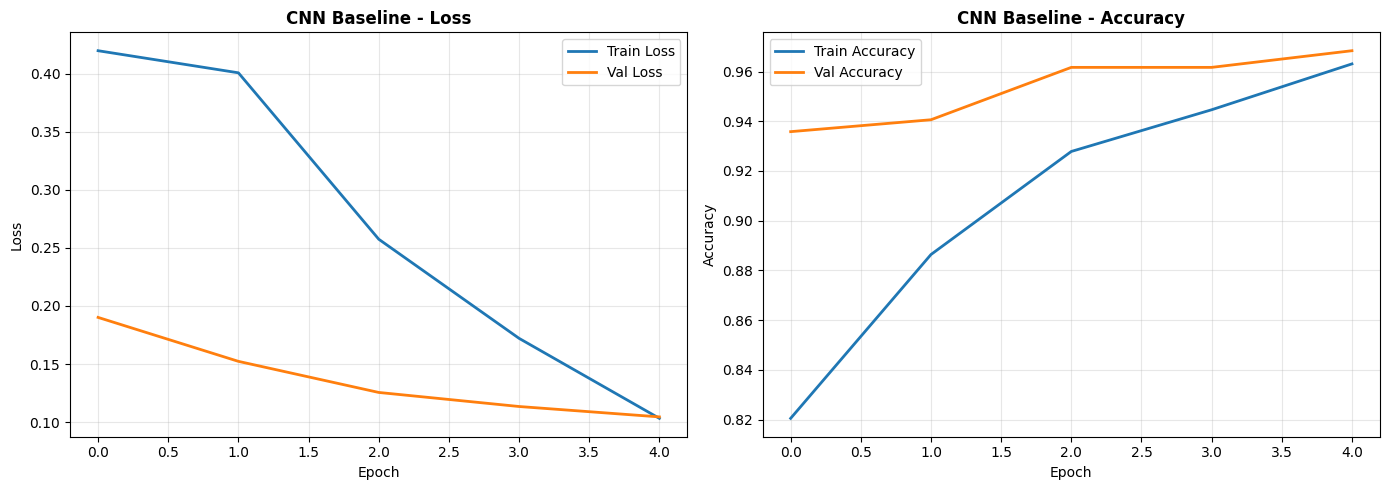

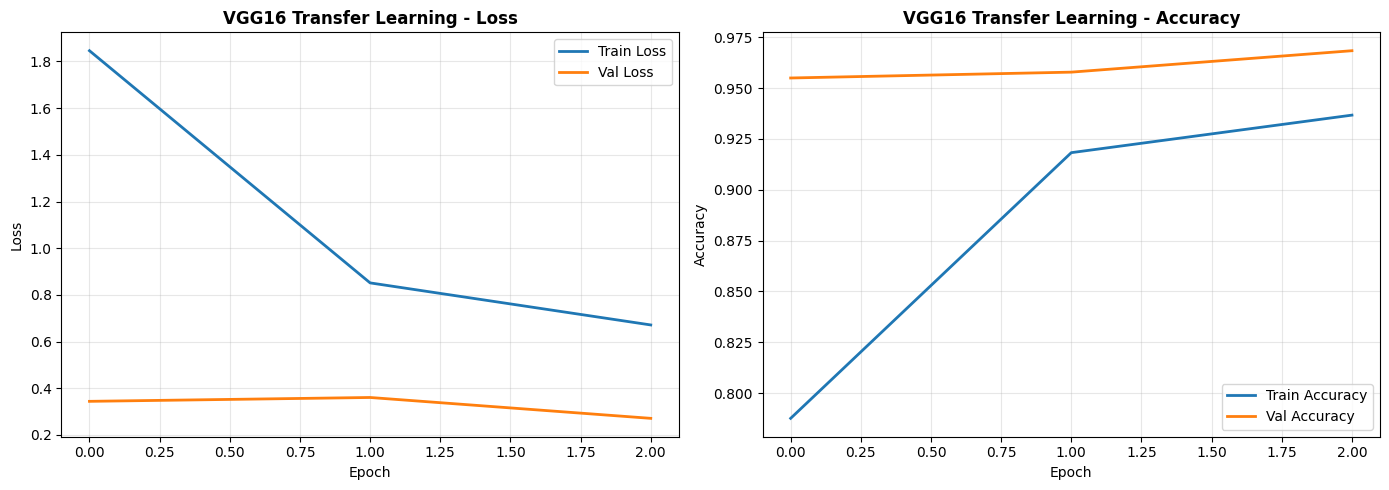

In [12]:
# Fonction pour visualiser les courbes d'entraînement
def plot_training_history(history, model_name):
    """Affiche les courbes de loss et accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualisation des deux modèles
plot_training_history(history_cnn, "CNN Baseline")
plot_training_history(history_vgg16, "VGG16 Transfer Learning")

## Évaluation des modèles

### Prédictions sur l'ensemble de test

In [13]:
# Prédictions sur l'ensemble de test
print("Génération des prédictions...")

# CNN Baseline
y_pred_cnn_prob = cnn_model.predict(X_test)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

# VGG16 Transfer Learning
y_pred_vgg16_prob = vgg16_model.predict(X_test_rgb)
y_pred_vgg16 = (y_pred_vgg16_prob > 0.5).astype(int).flatten()

print(f"Prédictions générées pour {len(y_test)} images de test")

Génération des prédictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
Prédictions générées pour 624 images de test


### Matrice de confusion

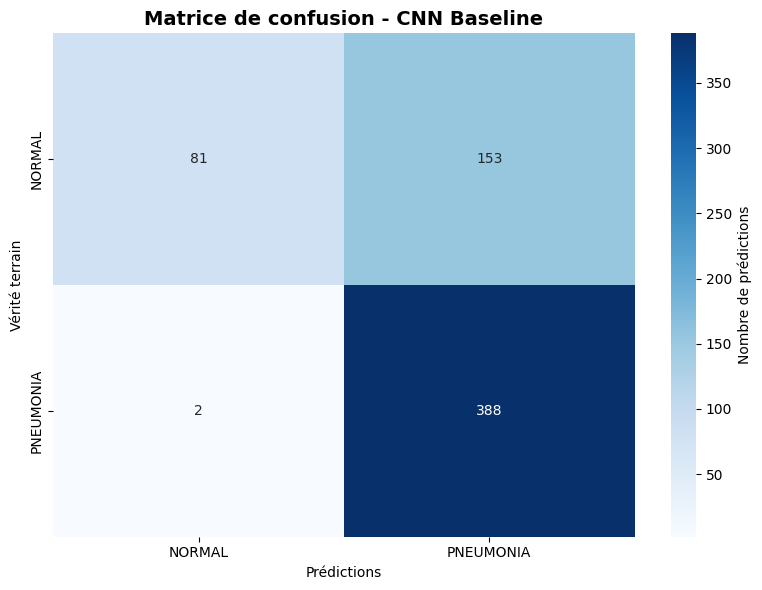

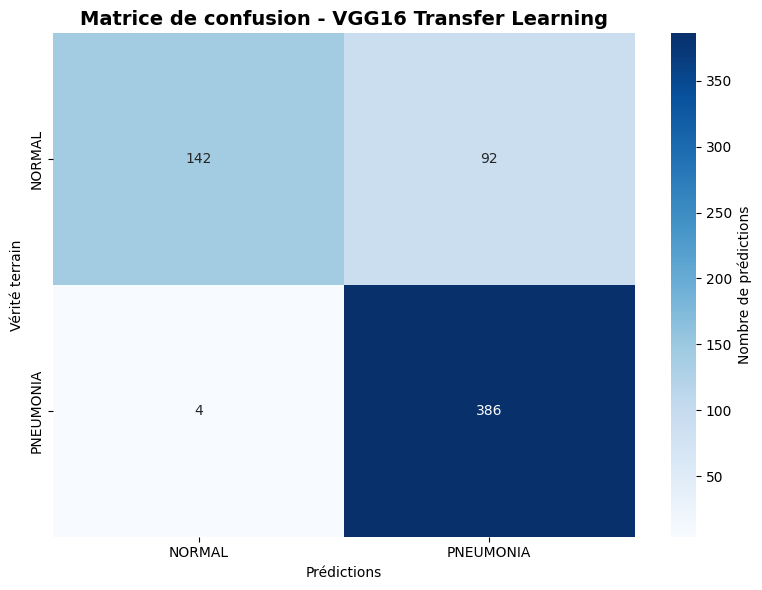

In [14]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Affiche la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, 
                yticklabels=CLASS_NAMES,
                cbar_kws={'label': 'Nombre de prédictions'})
    plt.title(f'Matrice de confusion - {model_name}', fontweight='bold', fontsize=14)
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédictions')
    plt.tight_layout()
    plt.show()
    
    return cm

# Matrices de confusion
cm_cnn = plot_confusion_matrix(y_test, y_pred_cnn, "CNN Baseline")
cm_vgg16 = plot_confusion_matrix(y_test, y_pred_vgg16, "VGG16 Transfer Learning")

### Métriques de performance détaillées

In [15]:
# Rapports de classification
print("=" * 70)
print("RAPPORT DE CLASSIFICATION - CNN BASELINE")
print("=" * 70)
print(classification_report(y_test, y_pred_cnn, target_names=CLASS_NAMES))

print("\n" + "=" * 70)
print("RAPPORT DE CLASSIFICATION - VGG16 TRANSFER LEARNING")
print("=" * 70)
print(classification_report(y_test, y_pred_vgg16, target_names=CLASS_NAMES))

RAPPORT DE CLASSIFICATION - CNN BASELINE
              precision    recall  f1-score   support

      NORMAL       0.98      0.35      0.51       234
   PNEUMONIA       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624


RAPPORT DE CLASSIFICATION - VGG16 TRANSFER LEARNING
              precision    recall  f1-score   support

      NORMAL       0.97      0.61      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



### Courbes ROC et AUC

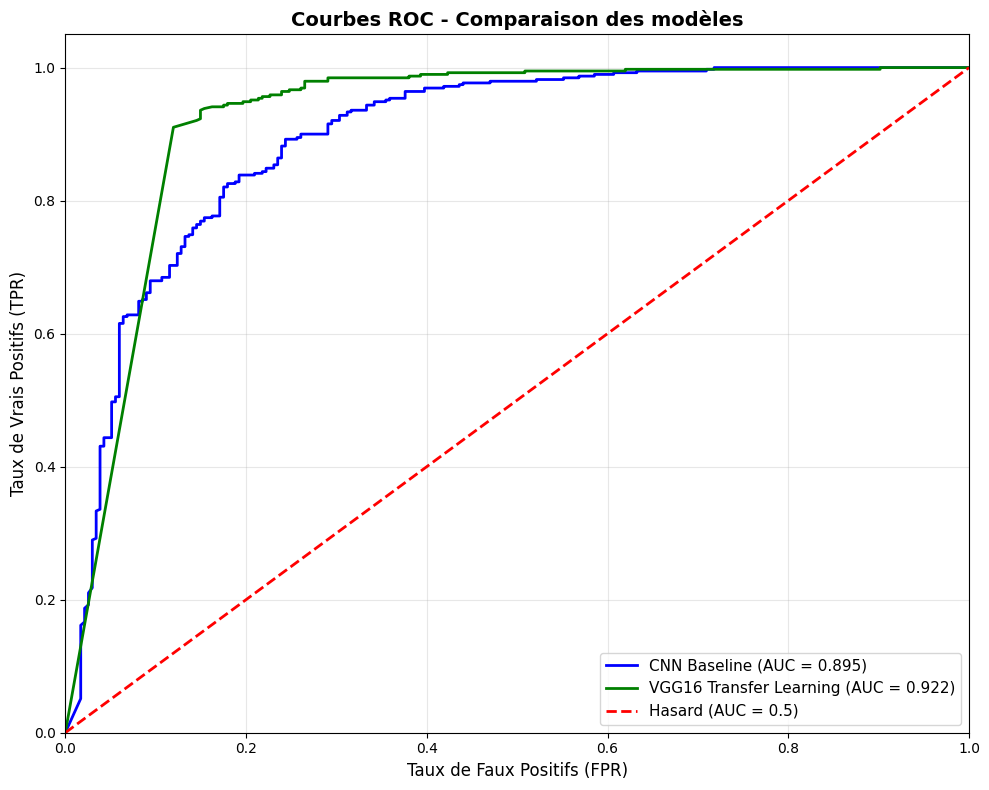

AUC CNN Baseline: 0.8952
AUC VGG16 Transfer Learning: 0.9225


In [16]:
# Calcul des courbes ROC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_vgg16, tpr_vgg16, _ = roc_curve(y_test, y_pred_vgg16_prob)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

# Visualisation
plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, 
         label=f'CNN Baseline (AUC = {roc_auc_cnn:.3f})')
plt.plot(fpr_vgg16, tpr_vgg16, color='green', lw=2, 
         label=f'VGG16 Transfer Learning (AUC = {roc_auc_vgg16:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
         label='Hasard (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des modèles', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC CNN Baseline: {roc_auc_cnn:.4f}")
print(f"AUC VGG16 Transfer Learning: {roc_auc_vgg16:.4f}")

## Comparaison finale et conclusions

### Tableau comparatif des performances

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcul des métriques pour chaque modèle
metrics_cnn = {
    'Accuracy': accuracy_score(y_test, y_pred_cnn),
    'Precision': precision_score(y_test, y_pred_cnn),
    'Recall': recall_score(y_test, y_pred_cnn),
    'F1-Score': f1_score(y_test, y_pred_cnn),
    'AUC': roc_auc_cnn
}

metrics_vgg16 = {
    'Accuracy': accuracy_score(y_test, y_pred_vgg16),
    'Precision': precision_score(y_test, y_pred_vgg16),
    'Recall': recall_score(y_test, y_pred_vgg16),
    'F1-Score': f1_score(y_test, y_pred_vgg16),
    'AUC': roc_auc_vgg16
}

# Création du DataFrame comparatif
comparison_df = pd.DataFrame({
    'CNN Baseline': metrics_cnn,
    'VGG16 Transfer Learning': metrics_vgg16
})

# Ajout d'une colonne de différence
comparison_df['Différence'] = comparison_df['VGG16 Transfer Learning'] - comparison_df['CNN Baseline']

print("=" * 80)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("=" * 80)
print(comparison_df.round(4))
print("\n")

# Analyse
print("ANALYSE:")
if metrics_vgg16['Accuracy'] > metrics_cnn['Accuracy']:
    print(f"Le modèle VGG16 Transfer Learning surpasse le CNN Baseline de " 
          f"{(metrics_vgg16['Accuracy'] - metrics_cnn['Accuracy'])*100:.2f}% en accuracy.")
else:
    print(f"Le CNN Baseline surpasse le VGG16 de "
          f"{(metrics_cnn['Accuracy'] - metrics_vgg16['Accuracy'])*100:.2f}% en accuracy.")

print(f"\nMeilleur F1-Score: {'VGG16' if metrics_vgg16['F1-Score'] > metrics_cnn['F1-Score'] else 'CNN Baseline'}")
print(f"Meilleur AUC: {'VGG16' if metrics_vgg16['AUC'] > metrics_cnn['AUC'] else 'CNN Baseline'}")

TABLEAU COMPARATIF DES PERFORMANCES
           CNN Baseline  VGG16 Transfer Learning  Différence
Accuracy         0.7516                   0.8462      0.0946
Precision        0.7172                   0.8075      0.0903
Recall           0.9949                   0.9897     -0.0051
F1-Score         0.8335                   0.8894      0.0559
AUC              0.8952                   0.9225      0.0272


ANALYSE:
Le modèle VGG16 Transfer Learning surpasse le CNN Baseline de 9.46% en accuracy.

Meilleur F1-Score: VGG16
Meilleur AUC: VGG16


### Conclusions et observations

**Points clés de l'expérimentation :**

1. **Transfer Learning vs CNN from scratch**
   - Le Transfer Learning avec VGG16 permet de bénéficier de features pré-apprises sur ImageNet
   - Seuls ~10% des paramètres sont entraînés (couches fully-connected), réduisant le temps d'entraînement
   - Les features de bas niveau (bords, textures) apprises sur ImageNet sont réutilisées

2. **Déséquilibre des classes**
   - Le dataset présente un ratio Pneumonia:Normal d'environ 3:1
   - Cela peut influencer les métriques (notamment le recall)
   - Des techniques comme le class weighting ou l'augmentation de données pourraient améliorer les résultats

3. **Métriques importantes en contexte médical**
   - **Recall (Sensibilité)** : Crucial pour ne pas manquer de cas de pneumonie (faux négatifs)
   - **Precision** : Important pour éviter les faux positifs
   - **F1-Score** : Bon compromis entre precision et recall
   - **AUC** : Mesure la capacité du modèle à discriminer les classes

4. **Limites et améliorations possibles**
   - Dataset relativement petit pour le deep learning
   - Validation set très réduit (16 images)
   - Pistes d'amélioration :
     * Data augmentation (rotation, zoom, flip)
     * Fine-tuning des dernières couches de VGG16
     * Essai d'autres architectures (ResNet, DenseNet, EfficientNet)
     * Utilisation de techniques d'ensemble
     * Gestion du déséquilibre des classes

**Conclusion finale :**

Ce Proof of Concept démontre la **faisabilité d'utiliser le Transfer Learning** pour la classification d'images médicales. Même avec un dataset limité et peu d'epochs d'entraînement, les modèles parviennent à apprendre des patterns discriminants pour détecter la pneumonie sur les radiographies thoraciques.

Le Transfer Learning s'avère particulièrement adapté aux contextes médicaux où :
- Les données annotées sont coûteuses à obtenir
- L'expertise médicale pour labelliser est limitée
- Le temps d'entraînement doit être réduit

Pour une mise en production, il faudrait :
- Valider sur un dataset externe plus large
- Obtenir l'aval de professionnels de santé
- Mettre en place un pipeline MLOps complet (monitoring, versioning, CI/CD)
- Garantir l'explicabilité des prédictions (Grad-CAM, attention maps)